# STATS 199 
***
### Examining Similarity of Online Publications with K-Means Clustering and PCA, or The Curse of Dimensionality with Traditional Unsupervised Methods on Text


### Introduction
This project aimed to examine the overall similarity between different publications using unsupervised machine learning techniques applied to the titles of hundreds of thousands of articles. The dataset used is called [*All the News*](https://www.kaggle.com/snapcrack/all-the-news) compiled by Andrew Thompson, and consists of 143,000 articles from fifteen different publications, which include the New York Times, Buzzfeed News, Breitbart News, Fox News, and others. 

Clustering is an unsupervised ML method that seeks to group data points together in natural "clusters", which are similar in some shape or form. We do this by converting each article into a point in an $n$ dimensional space, where $n$ is the number of unique words found in all articles. Each data point - that is, each article - can be represented in this $n$-space. After parsing the articles, we can talk about the $i$th word as corresponding to the $i$th dimension. If this word is present in the article, then the $i$th dimension in its representation has a value of 1, and if not, a value of 0. In this way we can define articles in this space. What we hope to do with clustering is identify distinct groups of articles, corresponding to different topics, and then use the proportion of a publication's articles in each cluster to identify similarities between publications and what the similarities are, qualitatively.

### Data

Each row in the CSV contains that article's author, the title, the text of the article, as well as several other fields that are unimportant to this research. I made sure to drop rows which were missing their title or the text. Since this is a huge (~253MB) dataset, we need to be very careful to not make costly operations, since an $O(n^2)$ operation on roughly 150,000 documents could take a very long time indeed.

## Assumptions

Although this dataset was collected from convienent sources like RSS feeds, we'll treat the articles as generally representative of the content put out by each outlet

We first define some utility functions and import all the libraries we'll need.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime, re, rpy2
import pandas as pd
import numpy as np
from nltk.stem.snowball import EnglishStemmer
from sklearn.preprocessing import scale, StandardScaler, maxabs_scale
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


def load_dataset(filename, n_sample=None):
    """Attempts to load csv at `filename`, exits with non-zero status code if
    fails. If optional `n_sample` argument is specified, randomly samples `n_sample`
    rows and returns that DataFrame. Returns all rows by default.
    """
    try:
        df = pd.read_csv(filename)
        if n_sample:
            df = df.sample(n_sample)
        return df
    except FileNotFoundError:
        print("File not found!")
        exit(1)
    except Exception as e:
        print(str(e))
        exit(2)

In [167]:
""" By default, returns a DataFrame with all articles after the given date. If the optional
keyword argument `before` is true, returns all articles before the given date. Defaults to the
date of the inauguration.
"""
def filter_since(year=2017, day=20, month=1, before=False, to_csv=False):
    filenames = ["article_data/articles1.csv",
                 "article_data/articles2.csv",
                 "article_data/articles3.csv"]
    
    df = pd.DataFrame()
    try:
        new_df = pd.read_csv(filename)
    except FileNotFoundError:
        print("File {} not found. Skipping...".format(filename))
    df = df.append(new_df)
    del new_df

    dt = datetime.datetime(day=day, month=month, year=year)
    df['date'] = pd.to_datetime(df['date'], yearfirst=True)
    
    if before:
        df = df.loc[df.date <= dt]
    else:
        df = df.loc[df.date > dt]
    
    if to_csv:
        if before:
            df.to_csv("before_{}_{}_{}.csv".format(day, month, year))
        else:
            df.to_csv("after_{}_{}_{}.csv".format(day, month, year))
    return df

""" Returns articles from publications in `publications` (a list). 
If optional argument `filter_out` is True, filters returns articles NOT
in `publications`.
"""
def filter_publications(publications, filter_out=False, filename=None):
    print("Filtering out publications:")
    print(", ".join(publications))
    df = pd.DataFrame()
    if filename:
        filenames = [filename]
    else:
        filenames = ["article_data/articles1.csv",
                     "article_data/articles2.csv",
                     "article_data/articles3.csv"]
    for filename in filenames:
        try:
            new_df = pd.read_csv(filename)
        except FileNotFoundError:
            print("File {} not found. Skipping...".format(filename))
            continue
        if filter_out:
            f = lambda x: x.lower() not in [publication.lower() for publication in publications]
        else:
            f = lambda x: x.lower() in [publication.lower() for publication in publications]
        print(df.columns)
        new_df = new_df.loc[new_df['publication'].apply(f)]
        print(new_df.head())
        df = df.append(new_df)
        del new_df
    for i in df.publication.unique().tolist():
        if filter_out:
            assert i not in publications
        else:
            assert i in publications
    return df


Next, we'll define some text processing functions. `stem_words` *stems* words, or changes them to a form without inflectional affixes. This means that a word like "going" changes to the infinitive form "go", or "is" changes to "be". The idea is that we reduce the dimensionality of the space while retaining the implicit semantic information in the word.

In [3]:
stemmer = EnglishStemmer()

""" Compresses consecutive whitespace characters, tokenizes with whitespace 
as word break, and then stems each word. Returns joined words.

Returns NON-STEMMED TITLES BY DEFAULT
CURRENTLY NOT BEING USED
"""
def stem_words(sentence, do_not_stem=True):
    
    sentence = re.sub("[\s]+", " ", sentence)
    if do_not_stem:
        return sentence
    words = [stemmer.stem(word) for word in sentence.split(" ")]
    return " ".join(words)
    
""" Removes consecutive whitespace characters, removes common phrases (that are problematic
because all titles with that phrase become their own cluster) and certain unicode characters.
The incredibly long first argument to `re.sub` is because successive function calls removing
all these phrases in sequence took incredibly long; it's ugly, but necessary.
"""
def clean_title(sentence, do_stem=False):
    sentence = re.sub("[\s]+", " ", sentence)
    sentence = re.sub("( - Breitbart)|([\s]+$)|(^[\s]+)|(as it happened)|(\u2019)|(\u2018)|(\u2013)|(\u201c)|(\u201d)|(\u00a0)|( - The New York Times)|(The Atlantic Politics & Policy Daily:)|(Fast Facts:)|(Your (Monday)?(Tuesday)?(Wednesday)?(Thursday)?(Friday)? Evening Briefing)|(The Atlantic Daily:)", " ", sentence)
    if do_stem:
        words = [stemmer.stem(word) for word in sentence.split(" ")]
        return " ".join(words)
    return sentence

Lastly, we define a function `run_cluster`, which takes in a sklearn cluster class, which is a subclass of sklearn's BaseEstimator, ClusterMixin, and TransformerMixin classes. It also takes the filename, the number of features to retain, and the range of $n$-grams to create. An $n$-gram is a grouping of $n$ words that appear consecutively. I used a range from one, to three, meaning that a document consisting of "The dog ate the apple" first would be converted to lowercase, and then would be represented in the feature space as each of its individual words, as well as "the dog" ,"dog ate", "ate the", "the apple", and then "the dog ate", "dog ate the", and "ate the apple". 

The point of grouping consecutive words together like this is that words mean different things in different contexts: father can be a noun or a verb, but we don't know which, if it's stripped of its context. If we don't have just one word ("father"), but two or more ("the father" or "to father") we can retain a word's context and the implicit information that it carries.

It clusters the given text after preprocessing them and turning them into vectors. It then does principal component analysis on the results by publication, where the results are the number of items in each cluster group by publication.

### TF-IDF

We use TF-IDF weights in our clustering analysis. Term Frequency - Inverse Document Frequency is a strategy that hopes to identify important, distinguishing words or short phrases ($n$-grams) between documents. Basically, the TF-IDF score for some particular $n$-gram is the number of times it appears in the document over the number of $n$-grams - which is term frequency - multiplied by the log of the number of documents in the corpus (group of documents) divided by the number of documents that have this particular term in them:

$$
TFIDF(t_{ij}) = \frac{\text{frequency}(t_i)}{\text{# terms in doc}_j}*log(\frac{\text{# documents}}{\text{# documents w/ term}})
$$

If a word only occurs in a few documents, then its score is larger, whereas if it occurs in many, or all (e.g. function words like "the", "a", and "to") then its score is close to zero. 
TF-IDF scores hope to identify *important distinguishing content words*, which is what we're trying to do.

In [164]:

""" Takes as input the initialized clustering class. 
`n_components` describes the number of principle components to use in the call to `get_pc`
`exclude` is an optional list of publications (as strings) 
to remove from the dataset before clustering. 
"""
def run_cluster(cluster_callable, filename, max_features, ngram_range, n_components=2, exclude=None, return_model=False, clustered=False, n_topics=None):
    if clustered:
        cluster_df = pd.read_csv(clustered)
        components = get_pc(cluster_df,
                        n_topics=n_topics,
                        n_components = n_components,
                        return_model=return_model)
        return components 
    if exclude:
        data = filter_publications(exclude, filter_out=True, filename=filename)
    else:
        data = load_dataset(filename)
    data.dropna(subset=['content', 'title'], inplace=True)
    vec = TfidfVectorizer(stop_words='english',
                          ngram_range=ngram_range,
                          max_features=max_features)
    
    titles = data['title'].apply(lambda x: clean_title(x, do_stem=True))
    transformed_docs = vec.fit_transform(titles).toarray()
    scaled_docs = transformed_docs / np.std(transformed_docs, ddof=1)
    
    clusters =  cluster_callable.fit_predict(scaled_docs)
    n_topics = pd.unique(clusters).size
        
    clusters_labels = [{'index': index.item(),
                        'cluster_label': cluster_label.item(),
                        'title': title,
                        'publication': publication} for index, cluster_label, title, publication in zip(np.arange(0, clusters.shape[0]), clusters, titles, data['publication'])]
    
    
    cluster_df = pd.DataFrame(clusters_labels)
    cluster_df.to_csv("clusters.csv")
    components = get_pc(cluster_df,
                        n_topics=n_topics,
                        n_components = n_components,
                        return_model=return_model)
    
    return components

***
## Grouping Publications with Principal Component Analysis
Next, we decompose the publication by cluster column feature matrix with Principal Component Analysis. This is a form of dimensionality reduction, and finds the lower-dimensional (given by n_components) subspace with the greatest variance. This means that we can reduce the dimensonality to either 2D or 3D along the axes that have the greatest spread, and plot it. Visualizing the differences between the publications, however abstract the units of measurement may be, may be helpful.

In [5]:
""" Returns `n_components` coefficients of first `n_components` principal component
basis vectors of column space of publication by cluster label count matrix, as well as
the unique publications, and optionally the PCA object itself.
That is, each row in the matrix is a different publication and each of the `n_topics` 
entries contains the count of its articles titles in that cluster. 
"""
def get_pc(df, n_topics, n_components, return_model=False):

    publications = pd.unique(df['publication'])
    init_matrix = np.zeros((publications.shape[0], n_topics))

    index_converter = {}
    for i,publication in enumerate(publications):
        index_converter[publication] = i

    for j in df.index:
        cluster = df.loc[j, 'cluster_label']
        init_matrix[index_converter[df.loc[j, 'publication']], cluster] += 1
    
    pca_model = PCA(n_components=n_components, svd_solver="randomized")
    
    scaled_matrix = scale(init_matrix, with_mean=True, with_std=False)
    
    components = pca_model.fit_transform(scaled_matrix)
    if return_model:
        return pca_model, components, publications
    return components, publications

### Unit variance normalization / KMeans assumptions
Normally, we do column normalization on the feature matrix before PCA so all columns are reduced to unit scale, such that every column has the same weight:

$$\tilde{x_{ij}} = \frac{x_{ij} - \bar{x_i}}{ s_i }$$

where:
- $\bar{x_i}$ is the sample mean of column $i$
- $s_i$ is the sample (unbiased) standard deviation of column $i$

However, since some columns (topics) might be more important in distinguishing different publications than others - in terms of their variance - we could make the conscious decision to not scale by the sample standard deviation and simply subtract the mean. This way, we avoid a common issue with PCA where the first principal component simply captures the mean of each feature column.

*However*, KMeans clustering assumes that every variable has the same variance, so we take the sample standard deviation of every value and scale the entire matrix by that amount.

In [6]:
n_topics=50
n_components=4
model, matrix, publications = run_cluster(cluster_callable=KMeans(n_clusters=n_topics),
                                          filename="../full_articles.csv", 
                                          max_features=1000,
                                          ngram_range=(2,2), 
                                          n_components=n_components,
                                          exclude=None,
                                          return_model=True, 
                                         clustered="clusters.csv",
                                         n_topics=50)

if n_components == 2:
    col_names = ['first', 'second']
elif n_components == 3:
    col_names = ['first', 'second', 'third']
elif n_components == 4:
    col_names = ['first', 'second', 'third', 'fourth']

assert n_components >= 2 and n_components <= 4

daf = pd.DataFrame(matrix, columns=col_names)  
daf.to_csv("k{}.csv".format(n_topics))

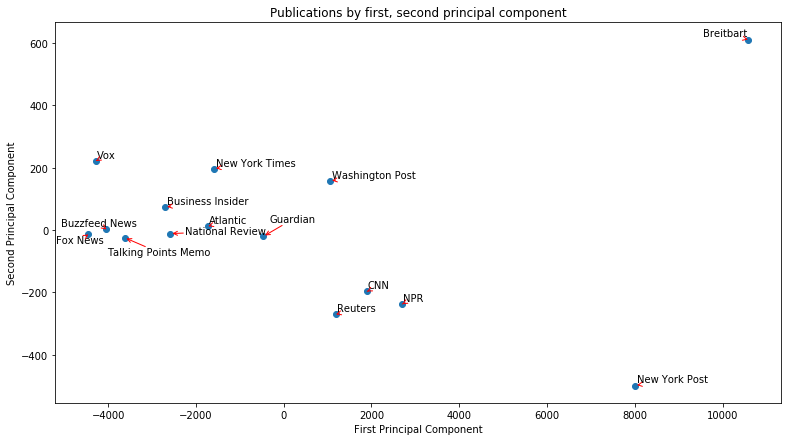

In [158]:
#%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure()
fig, ax = plt.subplots(figsize=(13,7))
ctr = 0
texts = []
for txt, x, y in zip(publications, matrix[:,0].tolist(), matrix[:,1].tolist()):
    texts.append(plt.text(x, y, txt))

        
plt.scatter(matrix[:,0], matrix[:,1])
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=1))
plt.title("Publications by first, second principal component")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

There's clearly something that hugely differentiates Breitbart and the New York Post from the rest of the publications. We can come up with reasons ourselves - for example, Breitbart seems to me infatuated with immigration - but we'll later attempt to determine exactly what that is. In any case, there is something hugely different about Breitbart that overrides everything else, and the same is true for the New York Post.

For the time being, let's ignore it and focus on the differences between the rest of the news sources. We'll rerun everything from the beginning EXCLUDING Breitbart and the New York Post.

In [ ]:
n_topics=50
n_components=4
model, matrix, publications = run_cluster(cluster_callable=KMeans(n_clusters=n_topics),
                                          filename="../full_articles.csv", 
                                          max_features=1000,
                                          ngram_range=(2,2), 
                                          n_components=4,
                                          exclude=["Breitbart", "New York Post"],
                                          return_model=True)

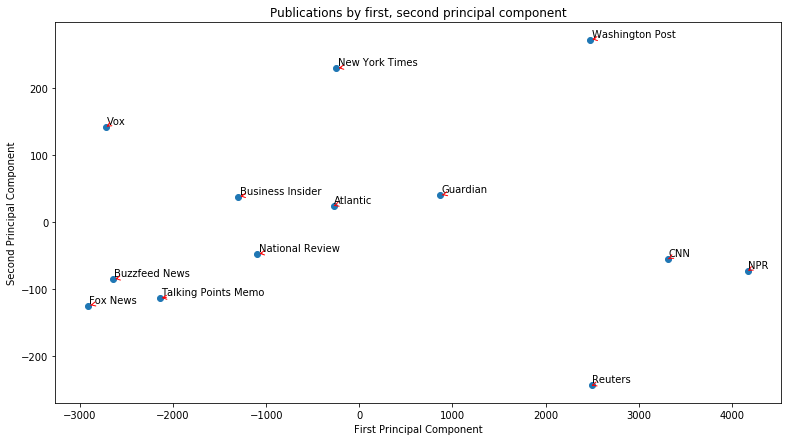

In [173]:
fig, ax = plt.subplots(figsize=(13,7))
ctr = 0
texts = []
for txt, x, y in zip(publications, matrix[:,0].tolist(), matrix[:,1].tolist()):
    texts.append(plt.text(x, y, txt))

        
plt.scatter(matrix[:,0], matrix[:,1])
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=1))
plt.title("Publications by first, second principal component")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

Wait - let's back up here. *Is KMeans clustering an appropriate method for this data?* KMeans makes the following assumptions, taken from __[here](https://www.r-bloggers.com/k-means-clustering-is-not-a-free-lunch/)__:

1. k-means assume the variance of the distribution of each attribute (variable) is spherical; 
2. all variables have the same variance; 
3. the prior probability for all k clusters are the same, i.e. each cluster has roughly equal number of observations; If any one of these 3 assumptions is violated, then k-means will fail.

Since we're assuming that these articles will naturally group together, that articles will naturally *fall into the same topic*, then we've already violated one of these assumptions. Intuitively, there are going to be far more articles on immigration, or national security, then there are on a small domestic story with only a few articles published. We've attempted to account for differing variance in the number of stories in each cluster, but just because we scale by the standard deviation doesn't mean that the items in each of the clusters have equal variance.

In [174]:
df = pd.read_csv("clusters.csv")
items = sorted(df.groupby("cluster_label").apply(lambda x: x.shape).tolist(), key=lambda x: x[0])
print("Size of maximum cluster: \t{}".format(items[-1][0]))
print("Size of minimum cluster: \t{}".format(items[0][0]))
print("Mean cluster size: \t\t{}".format(np.mean([i for i, j in items])))
print("Median cluster size: \t\t{}".format(np.median([i for i, j in items])))
cluster_records = [{"size": i, "cluster": j} for i,j in items]
cluster_df = pd.DataFrame(cluster_records)

Size of maximum cluster: 	88169
Size of minimum cluster: 	46
Mean cluster size: 		2025.88
Median cluster size: 		151.0


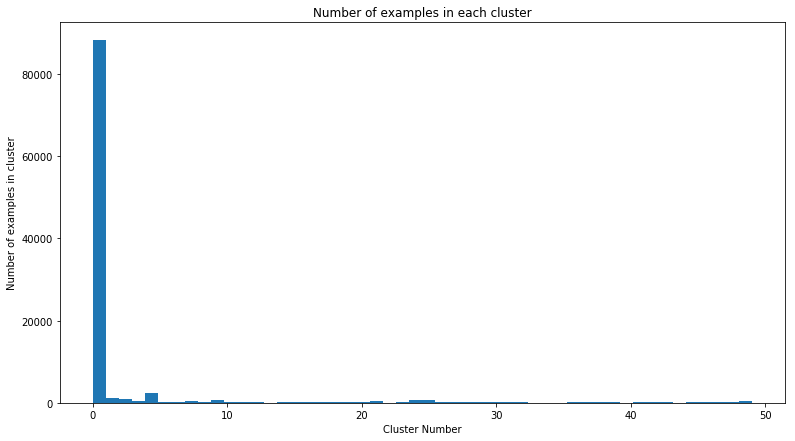

In [181]:
fig, ax = plt.subplots(figsize=(13,7))
plt.hist(df['cluster_label'], bins=50)
plt.title("Number of examples in each cluster")
plt.xlabel("Cluster Number")
plt.ylabel("Number of examples in cluster")
plt.show()

It's clear at this point that K-Means clustering has failed, in some sense: the majority of our samples reside in an enormous cluster, while there are many well-defined smaller clusters which correspond to coherent topics, for example, those that share a particular sequence of words in the title.

## Failure of KMeans
What happened here? Ultimately, the largest reason we didn't succeed is that *we weren't able to determine which features (words and phrases) were most important in distinguishing articles*. Even with the addition of TF-IDF weighting, we're unable to use this to achieve meaningful clusters, although it must be acknowledged that we have limited the maximum number of features to the 1000 most frequent words in the corpus. To cluster 150,000 individual data points in a 10,000 dimensional space could take a long, long time until the algorithm converges.
TF-IDF methods can be considered as naive but with the addition of a useful heuristic. However, we've shown that this is not enough to help describe any meaningful differences between these publications.

## Possible Ways Forward

Word embeddings are a way to capture semantic differences and similarities between words in a lower dimensional space, created by examining the closest neighbors to each word in the training text. In the words of Firth (1957), "a word is characterized by the company it keeps". We could use `word2vec`, a specific model for word embeddings developed at Google, to produce these embeddings.
In our vector space, we assign each word to a specific dimension, in this case, up to 1000. Word embeddings allow us to drop another 700 dimensions to a 300-space, as is standard in the word embedding literature and implementations. The benefit of this is that we don't discard *any* information (excluding words not present in the original training text) and are able to drop to a 300-space. Word embeddings have been shown to improve accuracy on classic machine learning tasks such as classification, so it's promising that they might help us derive more meaningful clusters. 
A common way to summarize an entire piece of text is to take the element-wise mean of all words in the text.

## Sources

1. Firth, J.R. (1957). "A synopsis of linguistic theory 1930-1955". Studies in Linguistic Analysis. Oxford: Philological Society: 1–32. Reprinted in F.R. Palmer, ed. (1968). Selected Papers of J.R. Firth 1952-1959. London: Longman.
2. Hunter, J. D. (2007). "Matplotlib: A 2D graphics environment". Computing In Science & Engineering. Vol 9, Number 3, 90-95
3. Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V. and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P. and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E. (2011). "Scikit-learn: Machine Learning in Python". Journal of Machine Learning Research. Vol 12, 2825-2830.